# 04 · Resumen y visualización de resultados

Este notebook inspecciona los **resultados de entrenos** y las **métricas continual**:

- Lee `outputs/continual_*/*/manifest.json` (o `metrics.json` si existiera) por **tarea**.
- Lee `outputs/continual_*/continual_results.json` por **run** (forgetting, MAE, etc.).
- Muestra un **DataFrame** y algunos **gráficos rápidos**.

> Requisitos:
> - Haber ejecutado `03_TRAIN_CONTINUAL.ipynb` (para que existan `continual_*` y sus JSON).
> - Estructura de salida por defecto en `./outputs/`.



## 1) Imports y rutas base


In [1]:
from pathlib import Path
import json, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# Raíz del repo (soporta ejecutar desde notebooks/ o raíz)
ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
OUT = ROOT / "outputs"

print("ROOT:", ROOT)
print("OUT :", OUT)


ROOT: /home/cesar/proyectos/TFM_SNN
OUT : /home/cesar/proyectos/TFM_SNN/outputs


## 2) Utilidades de parseo y lectura robusta

- `safe_read_json`: abre JSON y devuelve `{}` si no existe o está corrupto.
- `parse_exp_name`: extrae preset, método, encoder, semilla y modelo del nombre `continual_*`.
- `find_first_file`: busca un fichero (p.ej. `manifest.json` o `metrics.json`) en una carpeta.


In [2]:
def safe_read_json(path: Path):
    try:
        return json.loads(path.read_text(encoding="utf-8"))
    except Exception:
        return {}

ALLOWED_ENC = r"(rate|latency|raw|image)"
_pat = re.compile(
    rf"^continual_"
    rf"(?P<preset>[^_]+)_"
    rf"(?P<tag>.+)_"
    rf"(?P<enc>{ALLOWED_ENC})"
    rf"(?:_model\-(?P<model>.+?))?"
    rf"(?:_seed_(?P<seed>\d+))?$"
)

def parse_exp_name(name: str):
    meta = {"preset": None, "method": None, "lambda": None, "encoder": None, "seed": None, "model": None}
    m = _pat.match(name)
    if not m:
        return meta
    preset = m.group("preset"); tag = m.group("tag"); enc = m.group("enc")
    seed = m.group("seed"); model = m.group("model")
    mlam = re.search(r"_lam_([^_]+)", tag)
    if mlam:
        lam = mlam.group(1)
        method = tag.replace(f"_lam_{lam}", "")
    else:
        lam = None
        method = tag
    meta.update({
        "preset": preset,
        "method": method,
        "lambda": lam,
        "encoder": enc,
        "seed": int(seed) if seed is not None else None,
        "model": model
    })
    return meta

def find_first_file(folder: Path, candidates=("manifest.json", "metrics.json")) -> Path | None:
    for c in candidates:
        p = folder / c
        if p.exists():
            return p
    return None


## 3) Resumen “continual” (por run)

Lee `continual_results.json` en cada carpeta `outputs/continual_*` y computa:
- `c1_mae`, `c1_after_c2_mae`, `forgetting_abs`, `forgetting_rel_%`, `c2_mae`.



In [3]:
rows = []
for exp_dir in sorted(OUT.glob("continual_*")):
    res_path = exp_dir / "continual_results.json"
    if not res_path.exists():
        continue
    meta = parse_exp_name(exp_dir.name)
    res = safe_read_json(res_path)
    if not res:
        continue

    # Heurística para primera y última tarea
    task_names = list(res.keys())
    if len(task_names) < 2:
        continue

    def is_last(d: dict) -> bool:
        return not any(k.startswith("after_") for k in d.keys())

    first_task, last_task = None, None
    for tn in task_names:
        if is_last(res[tn]):
            last_task = tn
        else:
            first_task = tn

    if first_task is None or last_task is None:
        task_names_sorted = sorted(task_names)
        first_task = task_names_sorted[0]
        last_task  = task_names_sorted[-1]

    c1, c2 = first_task, last_task
    c1_test_mae = float(res[c1].get("test_mae", float("nan")))
    c2_test_mae = float(res[c2].get("test_mae", float("nan")))
    after_key_mae = f"after_{c2}_mae"
    c1_after_c2_mae = float(res[c1].get(after_key_mae, float("nan")))
    forgetting_abs = c1_after_c2_mae - c1_test_mae
    forgetting_rel = (forgetting_abs / c1_test_mae * 100.0) if np.isfinite(c1_test_mae) and c1_test_mae!=0 else float("nan")

    rows.append({
        "exp": exp_dir.name,
        "preset": meta["preset"], "method": meta["method"], "lambda": meta["lambda"],
        "encoder": meta["encoder"], "model": meta["model"], "seed": meta["seed"],
        "c1_name": c1, "c2_name": c2,
        "c1_mae": c1_test_mae, "c1_after_c2_mae": c1_after_c2_mae,
        "c1_forgetting_mae_abs": forgetting_abs, "c1_forgetting_mae_rel_%": forgetting_rel,
        "c2_mae": c2_test_mae,
    })

df_runs = pd.DataFrame(rows)
print(f"runs en resumen: {len(df_runs)}")
display(df_runs.sort_values(["preset","method","encoder","lambda","seed"], na_position="last", ignore_index=True) if not df_runs.empty else df_runs)


runs en resumen: 9


,exp,preset,method,lambda,encoder,model,seed,c1_name,c2_name,c1_mae,c1_after_c2_mae,c1_forgetting_mae_abs,c1_forgetting_mae_rel_%,c2_mae
0,continual_fast_ewc_lam_1e+09_lam_1e+09_rate_mo...,fast,ewc,1e+09,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.172236,0.172326,0.000090,0.052250,0.232427
1,continual_fast_ewc_lam_1e+09_lam_1e+09_rate_mo...,fast,ewc,1e+09,rate,PilotNetSNN_66x200_gray,43,circuito1,circuito2,0.169534,0.169597,0.000063,0.037209,0.231211
2,continual_fast_ewc_lam_7e+08_lam_7e+08_rate_mo...,fast,ewc,7e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.172236,0.172333,0.000097,0.056096,0.232430
3,continual_fast_naive_rate_model-PilotNetSNN_66...,fast,naive,None,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.171964,0.172271,0.000307,0.178309,0.232399
4,continual_fast_naive_rate_model-SNNVisionRegre...,fast,naive,None,rate,SNNVisionRegressor_80x160_gray,42,circuito1,circuito2,0.177120,0.221733,0.044613,25.188146,0.177002
5,continual_fast_naive_rate_model-PilotNetSNN_66...,fast,naive,None,rate,PilotNetSNN_66x200_gray,43,circuito1,circuito2,0.173744,0.183369,0.009625,5.539713,0.239302
6,continual_fast_rehearsal_buf_5000_rr_20_rate_m...,fast,rehearsal_buf_5000_rr_20,None,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.172236,0.171564,-0.000673,-0.390627,0.232069
7,continual_fast_rehearsal_buf_5000_rr_20+ewc_la...,fast,rehearsal_buf_5000_rr_20+ewc,1e+09,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.169112,0.169201,0.000089,0.052627,0.231057
8,continual_fast_rehearsal_buf_5000_rr_20+ewc_la...,fast,rehearsal_buf_5000_rr_20+ewc,7e+08,rate,PilotNetSNN_66x200_gray,42,circuito1,circuito2,0.171964,0.171942,-0.000022,-0.012846,0.232243


## 4) Resumen de entrenamiento por tarea (manifest/metrics)

Busca carpetas `outputs/continual_*/*task_*` y lee el `manifest.json` (o `metrics.json`) para extraer:
- `epochs`, `batch_size`, `lr`, `amp`, `seed`, y últimas pérdidas (`train_loss`, `val_loss`).


In [4]:
task_rows = []
for exp_dir in sorted(OUT.glob("continual_*")):
    for task_dir in sorted(exp_dir.glob("task_*")):
        jf = find_first_file(task_dir)
        if jf is None:
            continue
        man = safe_read_json(jf)
        # Estructura esperada (del parche): {"epochs", "batch_size", "lr", "amp", "seed", "history": {"train_loss": [...], "val_loss": [...]} }
        history = man.get("history", {})
        train_hist = history.get("train_loss", [])
        val_hist   = history.get("val_loss", [])
        task_rows.append({
            "exp": exp_dir.name,
            "task": task_dir.name,
            "epochs": man.get("epochs"),
            "batch_size": man.get("batch_size"),
            "lr": man.get("lr"),
            "amp": man.get("amp"),
            "seed": man.get("seed"),
            "train_last": train_hist[-1] if train_hist else np.nan,
            "val_last": val_hist[-1] if val_hist else np.nan,
        })

df_tasks = pd.DataFrame(task_rows)
print(f"tareas encontradas: {len(df_tasks)}")
display(df_tasks.sort_values(["exp","task"], ignore_index=True) if not df_tasks.empty else df_tasks)


tareas encontradas: 18


,exp,task,epochs,batch_size,lr,amp,seed,train_last,val_last
0,continual_fast_ewc_lam_1e+09_lam_1e+09_rate_mo...,task_1_circuito1,2,64,0.001,True,42,0.047388,0.067198
1,continual_fast_ewc_lam_1e+09_lam_1e+09_rate_mo...,task_2_circuito2,2,64,0.001,True,42,18.315743,0.117045
2,continual_fast_ewc_lam_1e+09_lam_1e+09_rate_mo...,task_1_circuito1,2,64,0.001,True,43,0.047258,0.067004
3,continual_fast_ewc_lam_1e+09_lam_1e+09_rate_mo...,task_2_circuito2,2,64,0.001,True,43,15.428713,0.116214
4,continual_fast_ewc_lam_7e+08_lam_7e+08_rate_mo...,task_1_circuito1,2,64,0.001,True,42,0.047388,0.067198
5,continual_fast_ewc_lam_7e+08_lam_7e+08_rate_mo...,task_2_circuito2,2,64,0.001,True,42,12.911378,0.117047
6,continual_fast_naive_rate_model-PilotNetSNN_66...,task_1_circuito1,2,64,0.001,True,42,0.047658,0.067141
7,continual_fast_naive_rate_model-PilotNetSNN_66...,task_2_circuito2,2,64,0.001,True,42,0.092427,0.117618
8,continual_fast_naive_rate_model-PilotNetSNN_66...,task_1_circuito1,2,64,0.001,True,43,0.047658,0.067592
9,continual_fast_naive_rate_model-PilotNetSNN_66...,task_2_circuito2,2,64,0.001,True,43,0.093885,0.125176


## 5) Gráficos rápidos

- Barras de `c1_mae` por experimento.
- Barras de “olvido relativo (%)” cuando esté disponible.


/tmp/ipykernel_19989/10320483.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


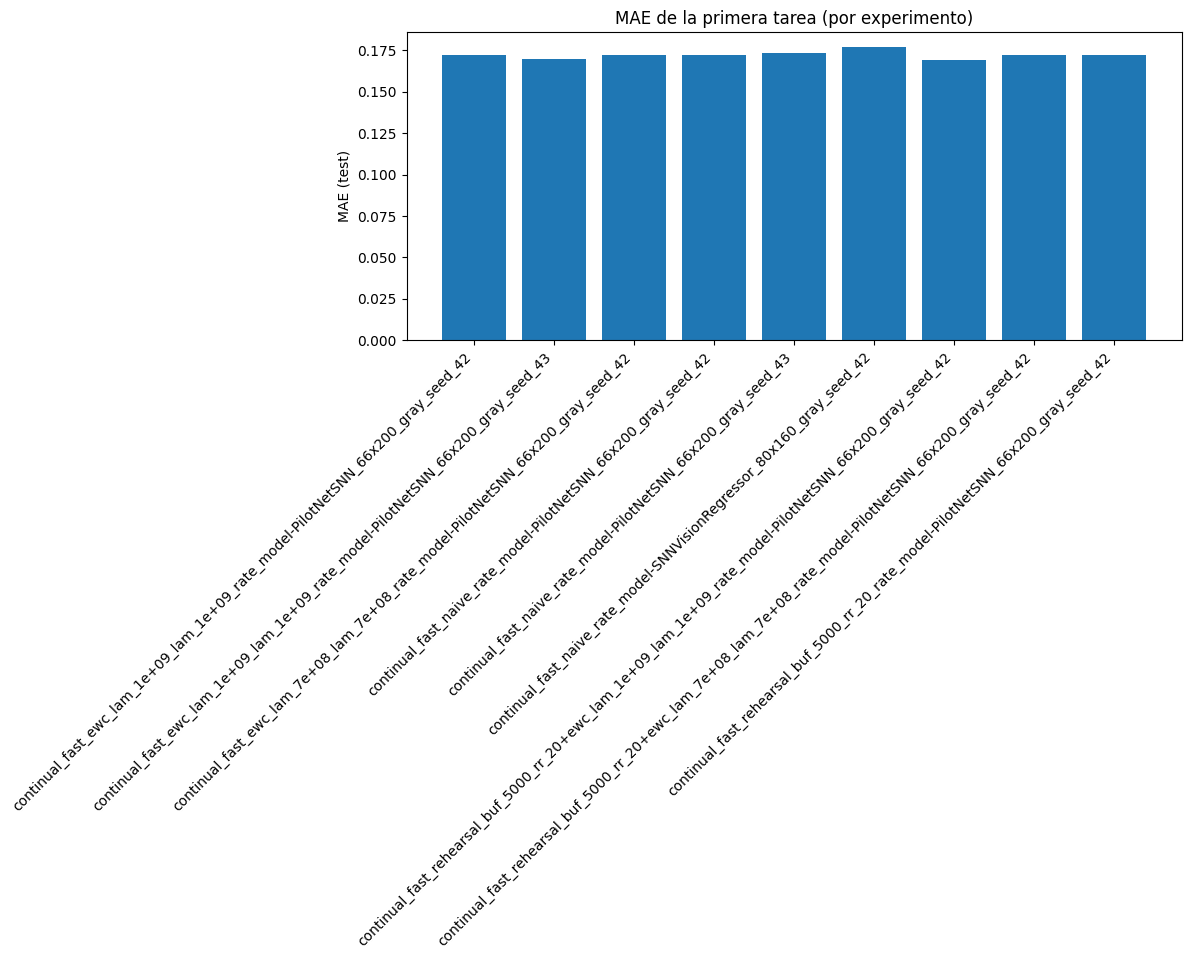

/tmp/ipykernel_19989/10320483.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


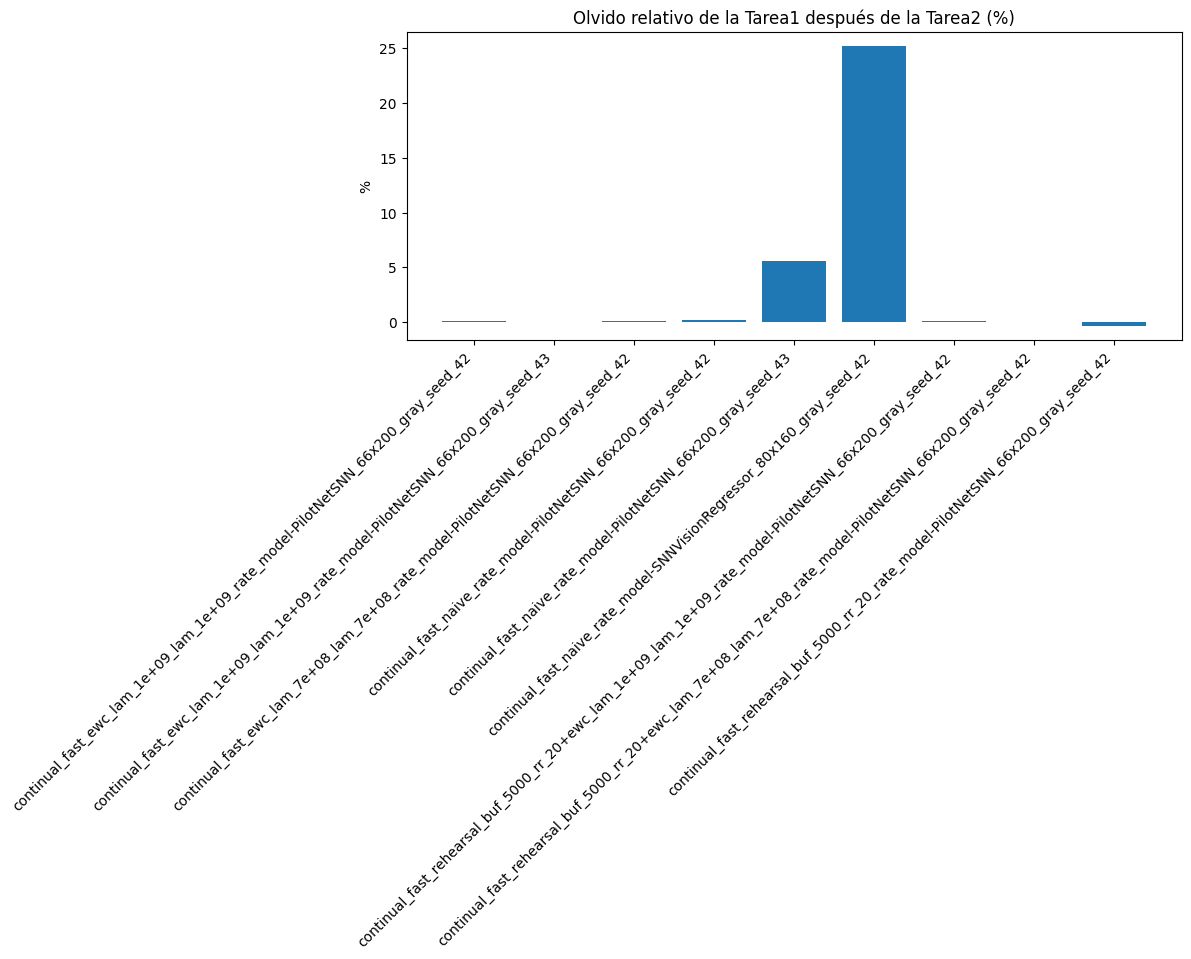

In [5]:
if df_runs.empty:
    print("No hay datos en df_runs; ejecuta entrenos en 03_TRAIN_CONTINUAL.ipynb primero.")
else:
    plt.figure(figsize=(10,4))
    order = df_runs["exp"].tolist()
    plt.bar(order, df_runs["c1_mae"])
    plt.title("MAE de la primera tarea (por experimento)")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("MAE (test)")
    plt.tight_layout()
    plt.show()

    if "c1_forgetting_mae_rel_%" in df_runs.columns and df_runs["c1_forgetting_mae_rel_%"].notna().any():
        plt.figure(figsize=(10,4))
        plt.bar(order, df_runs["c1_forgetting_mae_rel_%"])
        plt.title("Olvido relativo de la Tarea1 después de la Tarea2 (%)")
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("%")
        plt.tight_layout()
        plt.show()


## 6) Inspección de un experimento concreto

Imprime el contenido de `continual_results.json` para un `exp` de interés (por defecto el más reciente).


In [6]:
# Escoge el más reciente o pon manualmente un nombre de carpeta continual_*
exps = sorted(OUT.glob("continual_*"), key=lambda p: p.stat().st_mtime, reverse=True)
if not exps:
    print("No hay carpetas continual_* en outputs/.")
else:
    exp_dir = exps[0]   # cámbialo si quieres otro
    cfile = exp_dir / "continual_results.json"
    print("Mostrando:", cfile if cfile.exists() else "(no existe continual_results.json)")
    if cfile.exists():
        pprint(safe_read_json(cfile))


Mostrando: /home/cesar/proyectos/TFM_SNN/outputs/continual_fast_ewc_lam_1e+09_lam_1e+09_rate_model-PilotNetSNN_66x200_gray_seed_43/continual_results.json
{'circuito1': {'after_circuito2_mae': 0.16959692082305083,
               'after_circuito2_mse': 0.047096711831954456,
               'test_mae': 0.16953383974601308,
               'test_mse': 0.047124020683395045},
 'circuito2': {'test_mae': 0.2312110461384417, 'test_mse': 0.09076434079310801}}
